#BAT AGN Exploratory Analysis: DecompIR Model Fits

This notebook takes a look at the fitting results for the BAT AGN using the model from DecompIR (Mullaney+11).

This model is a template fitting model that contains several AGN templates as well as 5 host galaxy templates that were constructed based on the SEDs from Brandl et al 2006. For our fitting purposes I chose the mean AGN template to use along with the 5 host galaxy templates. I also threw in the SED from Arp 220 which represents a ULIRG. 

Fitting was done by maximizing the likelihood for which we used a Gaussian. For each source we calculated the 'AGN fraction' to the IR luminosity by simply integrating the best fit AGN template and dividing by the total luminosity.

Best fit parameters and uncertainties are located in the file 'final_fit_results_decompir_sb_and_arp220.csv'

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

sn.set(context='notebook', style='darkgrid', color_codes=True, palette='deep')

In [37]:
# Upload the fitting results
bat_fits = pd.read_csv('/Users/ttshimiz/Github/bat-agn-sed-fitting/analysis/decompir_results/sb+arp220/final_fit_results_decompir_sb_and_arp220_mle.csv', index_col=0)

In [38]:
# Remove the 'bad' sources
bad_sources = np.array(['PICTORA', '3C111.0', '3C120',
                        '2MASXJ23272195+1524375', 'PKS2331-240',
                        'HB890241+622', 'Mrk3', 'IC1657', 'IC2461',
                        'MCG-01-05-047', 'NGC788', 'NGC2655',
                        'NGC3718', 'NGC4939', 'NGC4941',
                        'NGC5033', 'NGC4235', 'CenA'])
bat_fits = bat_fits.drop(bad_sources)

Lets look at the best fit parameter distributions.

First 8-1000 micron luminosity:

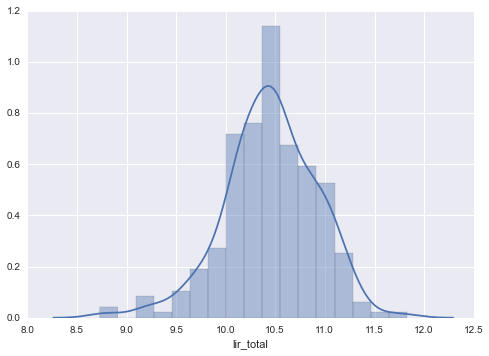

In [39]:
sn.distplot(bat_fits['lir_total'])

Looks like a Gaussian distribution with a slight tail towards high luminosity. Median looks to be out $10^{10.4} L_{\odot}$ with a spread of about 0.5 dex.

In [40]:
print 'Median LIR = ', bat_fits['lir_total'].median()
print 'Sigma LIR = ', bat_fits['lir_total'].std()

Median LIR =  10.4619253207
Sigma LIR =  0.466130889668


Now lets break it up into the two components: LSB and LAGN which are the starburst and AGN components. These aren't saved in the file specifically, rather what we have is the total luminosity and the AGN fraction. So LAGN is just the AGN fraction multiplied by the total and the starburst luminosity is what's leftover after subtracting out the AGN.

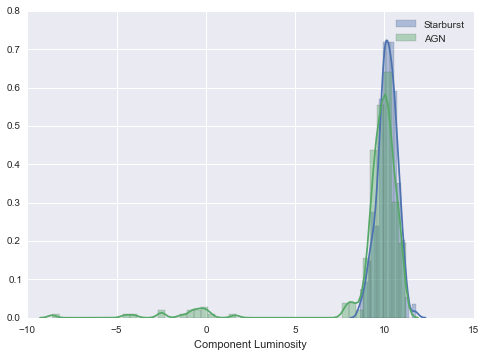

In [41]:
bat_fits['lir_agn'] = np.log10(bat_fits['agn_frac']*10**(bat_fits['lir_total']))
bat_fits['lir_sb'] = np.log10((1-bat_fits['agn_frac'])*10**(bat_fits['lir_total']))
ax = sn.distplot(bat_fits['lir_sb'])
sn.distplot(bat_fits['lir_agn'])
ax.set_xlabel('Component Luminosity')
ax.legend(['Starburst', 'AGN'])

It looks like some of the sources that have no AGN luminosity are causing the distribution to be skewed very far to low luminosity. Lets just look at the distribution for the AGN fraction.

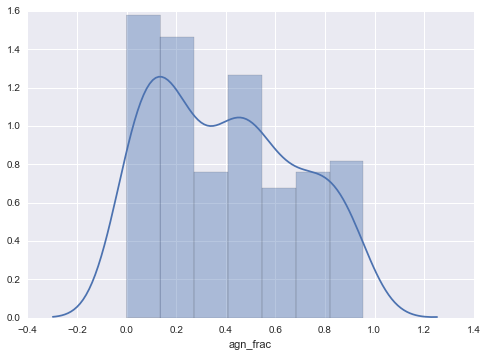

In [42]:
sn.distplot(bat_fits['agn_frac'])

This is interesting because there seems to be more sources with low AGN fraction compared to when we used the Casey 2012 model which looked more like a uniform distribution with a possible peak around 0.6.

In [43]:
print 'Median AGN Fraction = ', bat_fits['agn_frac'].median()
print 'Sigma AGN Fraction = ', bat_fits['agn_frac'].std()
print ''
print 'Median Starburst LIR = ', bat_fits['lir_sb'].median()
print 'Sigma Starburt LIR = ', bat_fits['lir_sb'].std()
print ''
print 'Median AGN LIR = ', bat_fits['lir_agn'].median()
print 'Sigma AGN LIR = ', bat_fits['lir_agn'].std()

Median AGN Fraction =  0.388086791659
Sigma AGN Fraction =  0.284350537154

Median Starburst LIR =  10.1648901504
Sigma Starburt LIR =  0.546567928316

Median AGN LIR =  9.90679128143
Sigma AGN LIR =  2.83327804267


The median AGN fraction is also slightly lower at 39% compared to 44% for the Casey model. Both have the same standard deviation however at 28%. 

Lets look at the distribution of the host galaxy templates used for the sources.

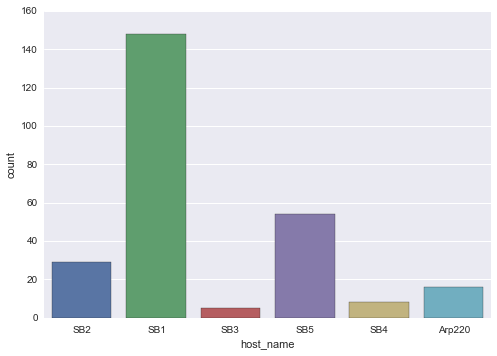

In [44]:
sn.countplot(bat_fits['host_name'])

Looks like most of the BAT AGN were fit with the 'SB1' template which matches what was used for the HRS. However there is definitely a larger fraction using the other templates especially 'SB5' which indicates there are more starbursting galaxies in the BAT AGN than HRS. Again expected since the BAT AGN are at higher stellar mass than the HRS.

What about the correlation between AGN fraction and AGN luminosity?
Once again we'll use the BAT luminosity as our proxy for AGN luminosity.

In [45]:
bat_flux = pd.read_csv('/Users/ttshimiz/Github/bat-data/bat_bat_flux.csv', index_col=0)
bat_info = pd.read_csv('/Users/ttshimiz/Github/bat-data/bat_info.csv', index_col=0)
bat_fits['LBAT'] = 4*np.pi*(bat_info['Dist_[Mpc]']*10**6*3.09e18)**2*bat_flux['BAT_flux']

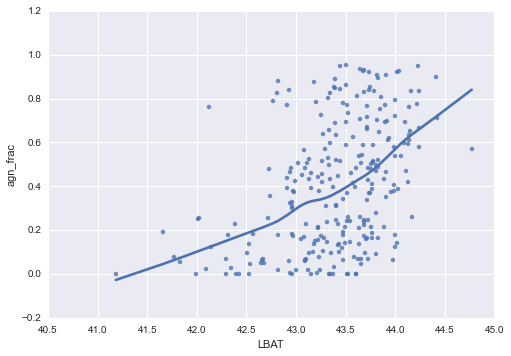

In [46]:
sn.regplot(x=np.log10(bat_fits['LBAT']), y=bat_fits['agn_frac'], lowess=True)

Like for the Casey model, there doesn't seem to be a very strong correlation between the AGN fraction and AGN luminosity. The correlations look essentially the same.

Finally what about the correlations between the AGN IR luminosity, SF luminosity, and AGN X-ray luminosity.

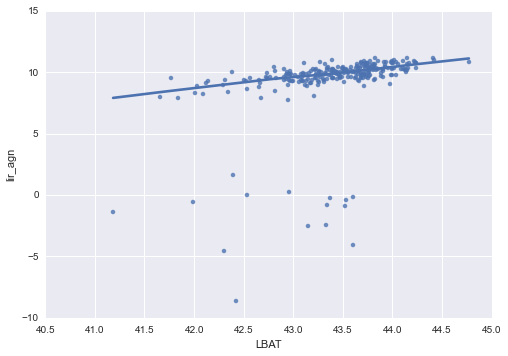

In [47]:
sn.regplot(x=np.log10(bat_fits['LBAT']), y=bat_fits['lir_agn'], lowess=True)

The sources with essentially zero AGN luminosity are distorting the plot so I'll restrict it to only the sources with log(LIR_AGN) > 5.0.

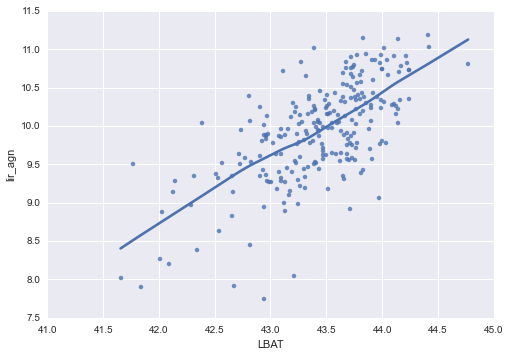

In [48]:
sn.regplot(x=np.log10(bat_fits['LBAT'][bat_fits['lir_agn'] > 5.0]), y=bat_fits['lir_agn'][bat_fits['lir_agn'] > 5.0], lowess=True)

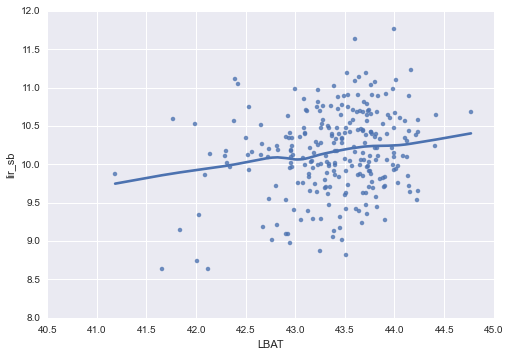

In [49]:
sn.regplot(x=np.log10(bat_fits['LBAT']), y=bat_fits['lir_sb'], lowess=True)

In [50]:
from scipy.stats import spearmanr, pearsonr
ind_use = bat_fits['lir_agn'] > 5.0
lbat_lagnIR_spearman = spearmanr(np.log10(bat_fits['LBAT'][ind_use]), np.log10(bat_fits['lir_agn'][ind_use]))
lbat_lsf_spearman = spearmanr(np.log10(bat_fits['LBAT']), np.log10(bat_fits['lir_sb']))

lbat_lagnIR_pearson = pearsonr(np.log10(bat_fits['LBAT'][ind_use]), np.log10(bat_fits['lir_agn'][ind_use]))
lbat_lsf_pearson = pearsonr(np.log10(bat_fits['LBAT']), np.log10(bat_fits['lir_sb']))

In [52]:
print 'Spearman Rank Correlation Coefficients:'
print 'LBAT vs LAGN_IR: ', lbat_lagnIR_spearman[0]
print 'LBAT vs LSF: ', lbat_lsf_spearman[0]
print ''
print 'Pearson Rank Correlation Coefficients:'
print 'LBAT vs LAGN_IR: ', lbat_lagnIR_pearson[0]
print 'LBAT vs LSF: ', lbat_lsf_pearson[0]

Spearman Rank Correlation Coefficients:
LBAT vs LAGN_IR:  0.641469942635
LBAT vs LSF:  0.173566290808

Pearson Rank Correlation Coefficients:
LBAT vs LAGN_IR:  0.672526793144
LBAT vs LSF:  0.233347536777


Just as with the Casey model, the BAT and IR AGN luminosity are much better correlated than the star-forming and BAT luminosity. This seems to be a fairly consistent result and evidence that we are decomposing the SEDs pretty well into the two components. The correlation coefficients for the BAT and IR AGN luminosity are slightly better using the DecompIR model than the Casey model (0.65 vs 0.62 and 0.68 vs 0.61) so it will be interesting to see what reason that could be.